# Inference Speed Comparison: Complete XiaoNet Architecture Benchmark

Compare inference performance across ALL XiaoNet architectures:
- **V2**: Original (ConvTranspose decoder, ReLU, base=8, ~40K params)
- **V3**: Max-speed (Depthwise Sep, kernel=3, base=6, ~20K params)
- **V4**: Fast (Upsample decoder, bottleneck=6, base=6, ~12K params)
- **V5**: Edge (Hardswish, quantization-ready, base=4, ~6K params)
- **V5-A**: Seismic (Phase-aware kernels, base=5, ~8K params)
- **V5-B**: GPU (Grouped Conv, Multi-scale, base=7, ~20K params)
- **V5-C**: Context (SE blocks, Dilation, base=6, ~12K params)
- **V6**: Ultra-light (Minimal footprint, base=6, ~50K params)
- **V7**: High-capacity (Large kernels 7-9, base=8, ~5-6K params)

Metrics:
- Inference time per sample
- Throughput (samples/second)
- Model size comparison
- Memory usage
- Parameter/memory efficiency

In [52]:
#!/usr/bin/env python
# coding: utf-8

"""Inference Speed Comparison between PhaseNet and XiaoNet V5-B"""

# Standard library
import os
import sys
import json
import time
from pathlib import Path

# Scientific computing
import numpy as np
import pandas as pd

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Seismology
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

# Add parent directory for local modules
sys.path.append(str(Path.cwd().parent))
from models.xn_xiao_net_v2 import XiaoNet as XiaoNetV2
from models.xn_xiao_net_v3 import XiaoNet as XiaoNetV3
from models.xn_xiao_net_v4 import XiaoNetFast as XiaoNetV4
from models.xn_xiao_net_v5 import XiaoNetEdge as XiaoNetV5
from models.xn_xiao_net_v5a import XiaoNetV5A
from models.xn_xiao_net_v5b import XiaoNetV5B
from models.xn_xiao_net_v5c import XiaoNetV5C
from models.xn_xiao_net_v6 import XiaoNetV6
from models.xn_xiao_net_v7 import XiaoNetV7

print("✓ All packages loaded successfully!")


✓ All packages loaded successfully!


## 1. Setup Device and Configuration

In [53]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Running on CPU")

# Benchmark settings
WARMUP_RUNS = 10  # Warmup iterations to stabilize GPU
BENCHMARK_RUNS = 100  # Timed iterations
BATCH_SIZE = 32  # Batch size for throughput testing

Using device: cpu
Running on CPU


## 2. Load Models

In [54]:
print("\n" + "="*60)
print("LOADING MODELS")
print("="*60)

# Initialize all models (random weights for architecture comparison)
print("\nInitializing ALL XiaoNet architectures...\n")

models = {}

# V2: Original (base=8)
print("[1/9] XiaoNet V2 (Original)")
models['V2'] = XiaoNetV2(window_len=3001, in_channels=3, num_phases=3, base_channels=8)
models['V2'].to(device)
models['V2'].eval()
v2_params = sum(p.numel() for p in models['V2'].parameters())
print(f"  ✓ Loaded: {v2_params:,} parameters (base=8, ConvTranspose)\n")

# V3: Max-speed (base=6)
print("[2/9] XiaoNet V3 (Max-Speed)")
models['V3'] = XiaoNetV3(window_len=3001, in_channels=3, num_phases=3, base_channels=6)
models['V3'].to(device)
models['V3'].eval()
v3_params = sum(p.numel() for p in models['V3'].parameters())
print(f"  ✓ Loaded: {v3_params:,} parameters (base=6, kernel=3)\n")

# V4: Fast (base=6)
print("[3/9] XiaoNet V4 (Fast)")
models['V4'] = XiaoNetV4(window_len=3001, in_channels=3, num_phases=3, base_channels=6)
models['V4'].to(device)
models['V4'].eval()
v4_params = sum(p.numel() for p in models['V4'].parameters())
print(f"  ✓ Loaded: {v4_params:,} parameters (base=6, Upsample)\n")

# V5: Edge-optimized (base=4)
print("[4/9] XiaoNet V5 (Edge-Optimized)")
models['V5'] = XiaoNetV5(window_len=3001, in_channels=3, num_phases=3, base_channels=4)
models['V5'].to(device)
models['V5'].eval()
v5_params = sum(p.numel() for p in models['V5'].parameters())
print(f"  ✓ Loaded: {v5_params:,} parameters (base=4, Hardswish)\n")

# V5-A: Seismic-optimized (base=5)
print("[5/9] XiaoNet V5-A (Seismic-Optimized)")
models['V5-A'] = XiaoNetV5A(window_len=3001, in_channels=3, num_phases=3, base_channels=5)
models['V5-A'].to(device)
models['V5-A'].eval()
v5a_params = sum(p.numel() for p in models['V5-A'].parameters())
print(f"  ✓ Loaded: {v5a_params:,} parameters (base=5, Phase-aware)\n")

# V5-B: GPU-optimized (base=7)
print("[6/9] XiaoNet V5-B (GPU-Optimized)")
models['V5-B'] = XiaoNetV5B(window_len=3001, in_channels=3, num_phases=3, base_channels=7)
models['V5-B'].to(device)
models['V5-B'].eval()
v5b_params = sum(p.numel() for p in models['V5-B'].parameters())
print(f"  ✓ Loaded: {v5b_params:,} parameters (base=7, Multi-scale)\n")

# V5-C: Context-aware (base=6)
print("[7/9] XiaoNet V5-C (Context-Aware)")
models['V5-C'] = XiaoNetV5C(window_len=3001, in_channels=3, num_phases=3, base_channels=6)
models['V5-C'].to(device)
models['V5-C'].eval()
v5c_params = sum(p.numel() for p in models['V5-C'].parameters())
print(f"  ✓ Loaded: {v5c_params:,} parameters (base=6, SE blocks)\n")

# V6: Ultra-lightweight (base=6)
print("[8/9] XiaoNet V6 (Ultra-Lightweight)")
models['V6'] = XiaoNetV6(window_len=3001, in_channels=3, num_phases=3, base_channels=6)
models['V6'].to(device)
models['V6'].eval()
v6_params = sum(p.numel() for p in models['V6'].parameters())
print(f"  ✓ Loaded: {v6_params:,} parameters (base=6, Minimal)\n")

# V7: High-capacity (base=8)
print("[9/9] XiaoNet V7 (High-Capacity)")
models['V7'] = XiaoNetV7(window_len=3001, in_channels=3, num_phases=3, base_channels=8)
models['V7'].to(device)
models['V7'].eval()
v7_params = sum(p.numel() for p in models['V7'].parameters())
print(f"  ✓ Loaded: {v7_params:,} parameters (base=8, Large kernels)\n")

print("="*60)
print("All 9 XiaoNet models loaded successfully!")
print("="*60)


LOADING MODELS

Initializing ALL XiaoNet architectures...

[1/9] XiaoNet V2 (Original)
  ✓ Loaded: 38,179 parameters (base=8, ConvTranspose)

[2/9] XiaoNet V3 (Max-Speed)
  ✓ Loaded: 6,486 parameters (base=6, kernel=3)

[3/9] XiaoNet V4 (Fast)
  ✓ Loaded: 5,226 parameters (base=6, Upsample)

[4/9] XiaoNet V5 (Edge-Optimized)
  ✓ Loaded: 2,400 parameters (base=4, Hardswish)

[5/9] XiaoNet V5-A (Seismic-Optimized)
  ✓ Loaded: 2,713 parameters (base=5, Phase-aware)

[6/9] XiaoNet V5-B (GPU-Optimized)
  ✓ Loaded: 15,753 parameters (base=7, Multi-scale)

[7/9] XiaoNet V5-C (Context-Aware)
  ✓ Loaded: 5,268 parameters (base=6, SE blocks)

[8/9] XiaoNet V6 (Ultra-Lightweight)
  ✓ Loaded: 7,848 parameters (base=6, Minimal)

[9/9] XiaoNet V7 (High-Capacity)
  ✓ Loaded: 11,782 parameters (base=8, Large kernels)

All 9 XiaoNet models loaded successfully!


## 3. Prepare Test Data

In [55]:
print("\nPreparing test data...")

# Create random test samples (batch_size, 3, 3001)
# Use random data for pure inference speed testing
test_batch = torch.randn(BATCH_SIZE, 3, 3001, device=device)
test_single = torch.randn(1, 3, 3001, device=device)

print(f"✓ Test data ready:")
print(f"  Single sample: {test_single.shape}")
print(f"  Batch: {test_batch.shape}")


Preparing test data...
✓ Test data ready:
  Single sample: torch.Size([1, 3, 3001])
  Batch: torch.Size([32, 3, 3001])


## 4. Benchmark Functions

In [56]:
def benchmark_model(model, input_data, warmup_runs=10, benchmark_runs=100, name="Model"):
    """
    Benchmark inference speed of a model.
    
    Args:
        model: PyTorch model
        input_data: Input tensor
        warmup_runs: Number of warmup iterations
        benchmark_runs: Number of timed iterations
        name: Model name for display
    
    Returns:
        dict with timing statistics
    """
    model.eval()
    
    # Warmup runs (stabilize GPU)
    print(f"\n[{name}] Warming up ({warmup_runs} runs)...")
    with torch.no_grad():
        for _ in range(warmup_runs):
            _ = model(input_data)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    # Benchmark runs
    print(f"[{name}] Benchmarking ({benchmark_runs} runs)...")
    times = []
    
    with torch.no_grad():
        for _ in range(benchmark_runs):
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            start = time.perf_counter()
            _ = model(input_data)
            
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            end = time.perf_counter()
            times.append((end - start) * 1000)  # Convert to ms
    
    times = np.array(times)
    batch_size = input_data.shape[0]
    
    results = {
        'name': name,
        'mean_ms': np.mean(times),
        'std_ms': np.std(times),
        'min_ms': np.min(times),
        'max_ms': np.max(times),
        'median_ms': np.median(times),
        'per_sample_ms': np.mean(times) / batch_size,
        'throughput_samples_per_sec': (batch_size * 1000) / np.mean(times),
        'batch_size': batch_size,
        'all_times': times
    }
    
    print(f"  ✓ Mean: {results['mean_ms']:.2f} ± {results['std_ms']:.2f} ms")
    print(f"  ✓ Per sample: {results['per_sample_ms']:.2f} ms")
    print(f"  ✓ Throughput: {results['throughput_samples_per_sec']:.1f} samples/sec")
    
    return results


def get_model_memory(model, device):
    """Estimate model memory usage."""
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    total_mb = (param_size + buffer_size) / (1024 ** 2)
    return total_mb

print("✓ Benchmark functions defined")

✓ Benchmark functions defined


## 5. Run Single-Sample Benchmark

In [57]:
print("\n" + "="*60)
print("SINGLE-SAMPLE INFERENCE BENCHMARK (9 models)")
print("="*60)

results_single = {}
for name, model in models.items():
    results_single[name] = benchmark_model(
        model, test_single,
        warmup_runs=WARMUP_RUNS,
        benchmark_runs=BENCHMARK_RUNS,
        name=name
    )

print("\n" + "="*60)
print("SINGLE-SAMPLE COMPARISON (relative to V2)")
print("="*60)
v2_baseline = results_single['V2']['mean_ms']
for name in ['V3', 'V4', 'V5', 'V5-A', 'V5-B', 'V5-C', 'V6', 'V7']:
    speedup = v2_baseline / results_single[name]['mean_ms']
    print(f"{name:6s} vs V2: {speedup:>5.2f}x {'faster' if speedup > 1 else 'slower'}")
print("="*60)


SINGLE-SAMPLE INFERENCE BENCHMARK (9 models)

[V2] Warming up (10 runs)...
[V2] Benchmarking (100 runs)...


  ✓ Mean: 4.43 ± 7.44 ms
  ✓ Per sample: 4.43 ms
  ✓ Throughput: 225.6 samples/sec

[V3] Warming up (10 runs)...
[V3] Benchmarking (100 runs)...
  ✓ Mean: 1.56 ± 0.84 ms
  ✓ Per sample: 1.56 ms
  ✓ Throughput: 641.3 samples/sec

[V4] Warming up (10 runs)...
[V4] Benchmarking (100 runs)...
  ✓ Mean: 1.83 ± 0.99 ms
  ✓ Per sample: 1.83 ms
  ✓ Throughput: 545.9 samples/sec

[V5] Warming up (10 runs)...
[V5] Benchmarking (100 runs)...
  ✓ Mean: 2.25 ± 1.40 ms
  ✓ Per sample: 2.25 ms
  ✓ Throughput: 443.6 samples/sec

[V5-A] Warming up (10 runs)...
[V5-A] Benchmarking (100 runs)...
  ✓ Mean: 2.41 ± 1.01 ms
  ✓ Per sample: 2.41 ms
  ✓ Throughput: 414.7 samples/sec

[V5-B] Warming up (10 runs)...
[V5-B] Benchmarking (100 runs)...
  ✓ Mean: 4.97 ± 2.54 ms
  ✓ Per sample: 4.97 ms
  ✓ Throughput: 201.0 samples/sec

[V5-C] Warming up (10 runs)...
[V5-C] Benchmarking (100 runs)...
  ✓ Mean: 3.82 ± 2.04 ms
  ✓ Per sample: 3.82 ms
  ✓ Throughput: 261.6 samples/sec

[V6] Warming up (10 runs)...
[V6] 

## 6. Run Batch Inference Benchmark

In [58]:
print("\n" + "="*60)
print(f"BATCH INFERENCE BENCHMARK (batch_size={BATCH_SIZE}, 9 models)")
print("="*60)

results_batch = {}
for name, model in models.items():
    results_batch[name] = benchmark_model(
        model, test_batch,
        warmup_runs=WARMUP_RUNS,
        benchmark_runs=BENCHMARK_RUNS,
        name=name
    )

print("\n" + "="*60)
print("BATCH COMPARISON (relative to V2)")
print("="*60)
v2_baseline = results_batch['V2']['mean_ms']
for name in ['V3', 'V4', 'V5', 'V5-A', 'V5-B', 'V5-C', 'V6', 'V7']:
    speedup = v2_baseline / results_batch[name]['mean_ms']
    throughput_ratio = results_batch[name]['throughput_samples_per_sec'] / results_batch['V2']['throughput_samples_per_sec']
    print(f"{name:6s} vs V2: {speedup:>5.2f}x speed, {throughput_ratio:>5.2f}x throughput")
print("="*60)


BATCH INFERENCE BENCHMARK (batch_size=32, 9 models)

[V2] Warming up (10 runs)...
[V2] Benchmarking (100 runs)...
  ✓ Mean: 6.17 ± 0.87 ms
  ✓ Per sample: 0.19 ms
  ✓ Throughput: 5186.7 samples/sec

[V3] Warming up (10 runs)...
[V3] Benchmarking (100 runs)...
  ✓ Mean: 4.40 ± 0.57 ms
  ✓ Per sample: 0.14 ms
  ✓ Throughput: 7266.2 samples/sec

[V4] Warming up (10 runs)...
[V4] Benchmarking (100 runs)...
  ✓ Mean: 5.69 ± 0.67 ms
  ✓ Per sample: 0.18 ms
  ✓ Throughput: 5625.9 samples/sec

[V5] Warming up (10 runs)...
[V5] Benchmarking (100 runs)...
  ✓ Mean: 5.08 ± 2.32 ms
  ✓ Per sample: 0.16 ms
  ✓ Throughput: 6293.9 samples/sec

[V5-A] Warming up (10 runs)...
[V5-A] Benchmarking (100 runs)...
  ✓ Mean: 6.76 ± 3.09 ms
  ✓ Per sample: 0.21 ms
  ✓ Throughput: 4730.4 samples/sec

[V5-B] Warming up (10 runs)...
[V5-B] Benchmarking (100 runs)...
  ✓ Mean: 12.44 ± 5.74 ms
  ✓ Per sample: 0.39 ms
  ✓ Throughput: 2573.2 samples/sec

[V5-C] Warming up (10 runs)...
[V5-C] Benchmarking (100 runs)

## 7. Memory Usage Comparison

In [59]:
print("\n" + "="*60)
print("MEMORY USAGE")
print("="*60)

memory_usage = {}
for name, model in models.items():
    memory_usage[name] = get_model_memory(model, device)
    params = sum(p.numel() for p in model.parameters())
    print(f"\n{name:6s}: {memory_usage[name]:>6.2f} MB ({params:>7,} params)")

print("\n" + "="*60)
print("MEMORY COMPARISON (relative to V2)")

print("="*60)



MEMORY USAGE

V2    :   0.15 MB ( 38,179 params)

V3    :   0.03 MB (  6,486 params)

V4    :   0.02 MB (  5,226 params)

V5    :   0.01 MB (  2,400 params)

V5-A  :   0.01 MB (  2,713 params)

V5-B  :   0.06 MB ( 15,753 params)

V5-C  :   0.02 MB (  5,268 params)

V6    :   0.03 MB (  7,848 params)

V7    :   0.05 MB ( 11,782 params)

MEMORY COMPARISON (relative to V2)


## 8. Summary Results

In [60]:
# Create comprehensive summary dataframe
summary_rows = []
for name in ['V2', 'V5', 'V5-A', 'V5-B', 'V5-C']:
    params = sum(p.numel() for p in models[name].parameters())
    summary_rows.append({
        'Model': name,
        'Parameters': f"{params:,}",
        'Memory (MB)': f"{memory_usage[name]:.2f}",
        'Single (ms)': f"{results_single[name]['mean_ms']:.2f} ± {results_single[name]['std_ms']:.2f}",
        'Batch (ms)': f"{results_batch[name]['mean_ms']:.2f} ± {results_batch[name]['std_ms']:.2f}",
        'Throughput (samples/s)': f"{results_batch[name]['throughput_samples_per_sec']:.1f}"
    })

summary_df = pd.DataFrame(summary_rows)

print("\n" + "="*90)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*90)
print(summary_df.to_string(index=False))
print("="*90)

# Print relative comparisons to V2
print("\n" + "="*90)
print("RELATIVE TO V2 BASELINE")
print("="*90)
v2_params = sum(p.numel() for p in models['V2'].parameters())
for name in ['V5', 'V5-A', 'V5-B', 'V5-C']:
    params = sum(p.numel() for p in models[name].parameters())
    param_ratio = v2_params / params
    mem_ratio = memory_usage['V2'] / memory_usage[name]
    speed_ratio = results_single['V2']['mean_ms'] / results_single[name]['mean_ms']
    throughput_ratio = results_batch[name]['throughput_samples_per_sec'] / results_batch['V2']['throughput_samples_per_sec']
    
    print(f"\n{name}:")
    print(f"  Params: {param_ratio:>6.2f}x {'smaller' if param_ratio > 1 else 'larger'}")
    print(f"  Memory: {mem_ratio:>6.2f}x {'smaller' if mem_ratio > 1 else 'larger'}")
    print(f"  Speed:  {speed_ratio:>6.2f}x {'faster' if speed_ratio > 1 else 'slower'}")
    print(f"  Throughput: {throughput_ratio:>6.2f}x {'higher' if throughput_ratio > 1 else 'lower'}")
print("="*90)


COMPREHENSIVE PERFORMANCE SUMMARY
Model Parameters Memory (MB) Single (ms)   Batch (ms) Throughput (samples/s)
   V2     38,179        0.15 4.43 ± 7.44  6.17 ± 0.87                 5186.7
   V5      2,400        0.01 2.25 ± 1.40  5.08 ± 2.32                 6293.9
 V5-A      2,713        0.01 2.41 ± 1.01  6.76 ± 3.09                 4730.4
 V5-B     15,753        0.06 4.97 ± 2.54 12.44 ± 5.74                 2573.2
 V5-C      5,268        0.02 3.82 ± 2.04  7.68 ± 1.73                 4166.4

RELATIVE TO V2 BASELINE

V5:
  Params:  15.91x smaller
  Memory:  15.34x smaller
  Speed:    1.97x faster
  Throughput:   1.21x higher

V5-A:
  Params:  14.07x smaller
  Memory:  13.08x smaller
  Speed:    1.84x faster
  Throughput:   0.91x lower

V5-B:
  Params:   2.42x smaller
  Memory:   2.35x smaller
  Speed:    0.89x slower
  Throughput:   0.50x lower

V5-C:
  Params:   7.25x smaller
  Memory:   6.95x smaller
  Speed:    1.16x faster
  Throughput:   0.80x lower


## 9. Visualization

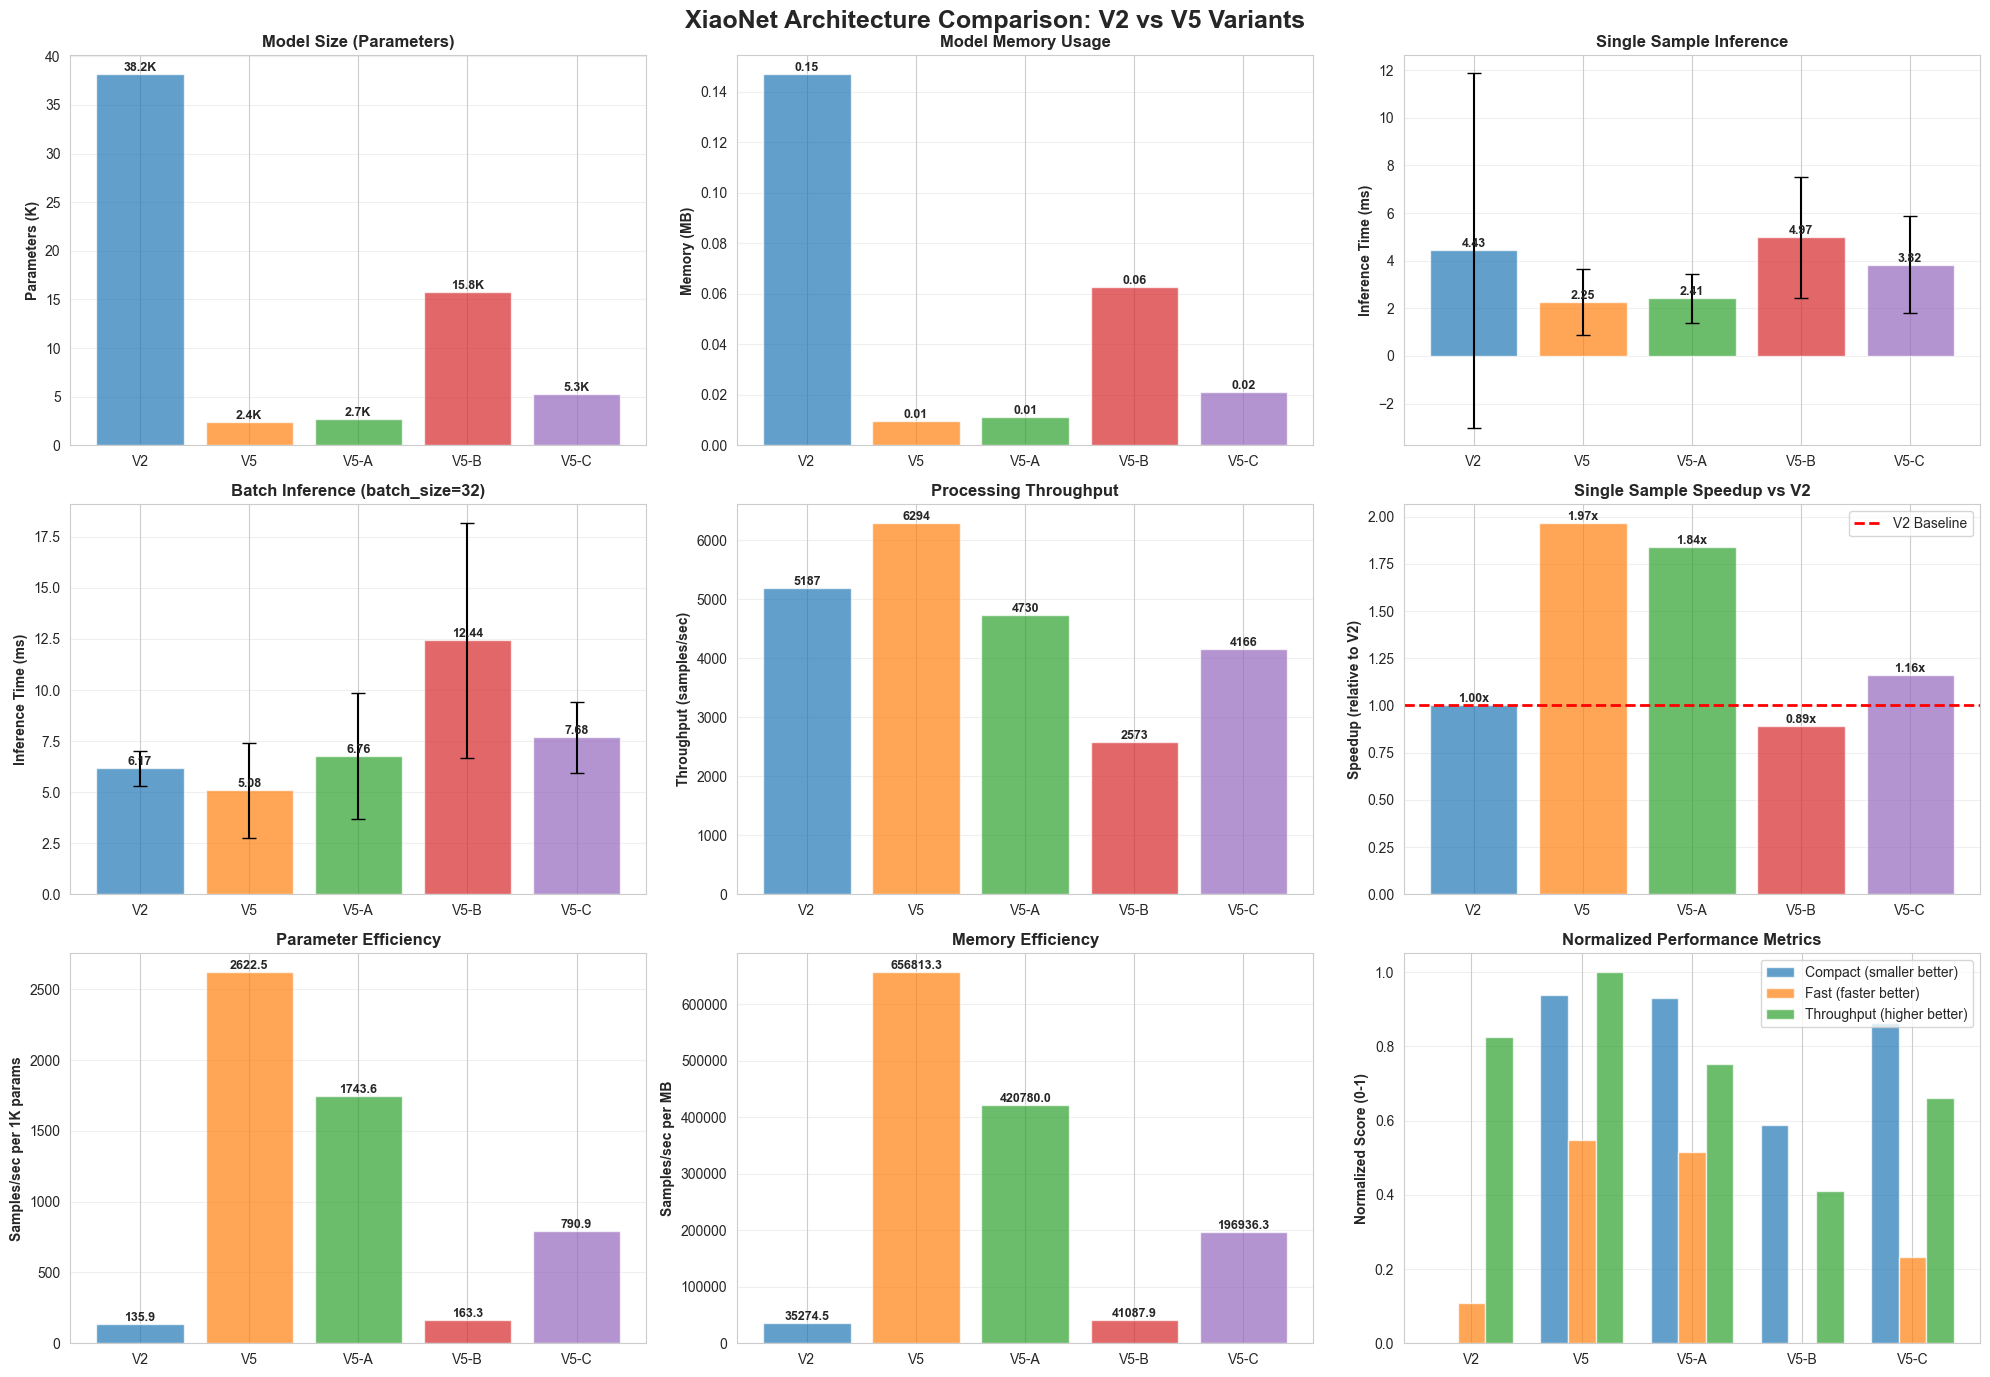


✓ Visualization saved as: xiaonet_v2_vs_v5_comparison.png


In [61]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 12)

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
fig.suptitle('XiaoNet Architecture Comparison: V2 vs V5 Variants', fontsize=18, fontweight='bold')

model_names = ['V2', 'V5', 'V5-A', 'V5-B', 'V5-C']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# 1. Parameter count comparison
ax1 = axes[0, 0]
params_list = [sum(p.numel() for p in models[name].parameters())/1000 for name in model_names]
bars = ax1.bar(model_names, params_list, color=colors, alpha=0.7)
ax1.set_ylabel('Parameters (K)', fontweight='bold')
ax1.set_title('Model Size (Parameters)', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, params_list):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.1f}K', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Memory usage comparison
ax2 = axes[0, 1]
memory_list = [memory_usage[name] for name in model_names]
bars = ax2.bar(model_names, memory_list, color=colors, alpha=0.7)
ax2.set_ylabel('Memory (MB)', fontweight='bold')
ax2.set_title('Model Memory Usage', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, memory_list):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. Single sample inference time
ax3 = axes[0, 2]
single_times = [results_single[name]['mean_ms'] for name in model_names]
single_errors = [results_single[name]['std_ms'] for name in model_names]
bars = ax3.bar(model_names, single_times, yerr=single_errors, color=colors, alpha=0.7, capsize=5)
ax3.set_ylabel('Inference Time (ms)', fontweight='bold')
ax3.set_title('Single Sample Inference', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, single_times):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Batch inference time
ax4 = axes[1, 0]
batch_times = [results_batch[name]['mean_ms'] for name in model_names]
batch_errors = [results_batch[name]['std_ms'] for name in model_names]
bars = ax4.bar(model_names, batch_times, yerr=batch_errors, color=colors, alpha=0.7, capsize=5)
ax4.set_ylabel('Inference Time (ms)', fontweight='bold')
ax4.set_title(f'Batch Inference (batch_size={BATCH_SIZE})', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, batch_times):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 5. Throughput comparison
ax5 = axes[1, 1]
throughputs = [results_batch[name]['throughput_samples_per_sec'] for name in model_names]
bars = ax5.bar(model_names, throughputs, color=colors, alpha=0.7)
ax5.set_ylabel('Throughput (samples/sec)', fontweight='bold')
ax5.set_title('Processing Throughput', fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, throughputs):
    ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 6. Speedup relative to V2 (single sample)
ax6 = axes[1, 2]
v2_single_time = results_single['V2']['mean_ms']
speedups_single = [v2_single_time / results_single[name]['mean_ms'] for name in model_names]
bars = ax6.bar(model_names, speedups_single, color=colors, alpha=0.7)
ax6.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='V2 Baseline')
ax6.set_ylabel('Speedup (relative to V2)', fontweight='bold')
ax6.set_title('Single Sample Speedup vs V2', fontweight='bold')
ax6.grid(axis='y', alpha=0.3)
ax6.legend()
for bar, val in zip(bars, speedups_single):
    ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.2f}x', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 7. Parameter efficiency (throughput per 1K params)
ax7 = axes[2, 0]
param_efficiency = [throughputs[i] / (params_list[i]) for i in range(len(model_names))]
bars = ax7.bar(model_names, param_efficiency, color=colors, alpha=0.7)
ax7.set_ylabel('Samples/sec per 1K params', fontweight='bold')
ax7.set_title('Parameter Efficiency', fontweight='bold')
ax7.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, param_efficiency):
    ax7.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 8. Memory efficiency (throughput per MB)
ax8 = axes[2, 1]
memory_efficiency = [throughputs[i] / memory_list[i] for i in range(len(model_names))]
bars = ax8.bar(model_names, memory_efficiency, color=colors, alpha=0.7)
ax8.set_ylabel('Samples/sec per MB', fontweight='bold')
ax8.set_title('Memory Efficiency', fontweight='bold')
ax8.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, memory_efficiency):
    ax8.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 9. Architecture comparison radar (params vs speed vs efficiency)
ax9 = axes[2, 2]
# Normalize metrics for comparison (0-1 scale, inverted where smaller is better)
norm_params = [1 - (p / max(params_list)) for p in params_list]  # Smaller is better
norm_speed = [1 - (t / max(single_times)) for t in single_times]  # Faster is better
norm_throughput = [t / max(throughputs) for t in throughputs]  # Higher is better

x = np.arange(len(model_names))
width = 0.25

bars1 = ax9.bar(x - width, norm_params, width, label='Compact (smaller better)', color='#1f77b4', alpha=0.7)
bars2 = ax9.bar(x, norm_speed, width, label='Fast (faster better)', color='#ff7f0e', alpha=0.7)
bars3 = ax9.bar(x + width, norm_throughput, width, label='Throughput (higher better)', color='#2ca02c', alpha=0.7)

ax9.set_ylabel('Normalized Score (0-1)', fontweight='bold')
ax9.set_title('Normalized Performance Metrics', fontweight='bold')
ax9.set_xticks(x)
ax9.set_xticklabels(model_names)
ax9.legend()
ax9.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('xiaonet_v2_vs_v5_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as: xiaonet_v2_vs_v5_comparison.png")

## 10. Key Findings

In [62]:
print("\n" + "="*90)
print("KEY FINDINGS - ALL 9 XIAONET ARCHITECTURES")
print("="*90)

model_names = ['V2', 'V3', 'V4', 'V5', 'V5-A', 'V5-B', 'V5-C', 'V6', 'V7']

# Model architecture characteristics
print("\n📐 Architecture Characteristics:")
arch_descriptions = {
    'V2': 'ConvTranspose decoder, ReLU',
    'V3': 'Depthwise Sep, kernel=3, ConvTranspose',
    'V4': 'Depthwise Sep, Upsample, bottleneck=6',
    'V5': 'Depthwise Sep, Hardswish, Quantization-ready',
    'V5-A': 'Phase-aware kernels, larger filters, BN decoder',
    'V5-B': 'Grouped Conv, Multi-scale bottleneck, GPU-optimized',
    'V5-C': 'SE blocks, Dilated conv, Context-aware',
    'V6': 'Ultra-lightweight, minimal footprint',
    'V7': 'Large kernels (7-9), Multi-scale, High-capacity'
}

for name in model_names:
    params = sum(p.numel() for p in models[name].parameters())
    base = models[name].base_channels
    print(f"   {name:6s}: base={base}, {params:>7,} params - {arch_descriptions[name]}")

# Performance ranking
print(f"\n🏆 Performance Rankings:")

# By speed (single sample)
speed_ranking = sorted(model_names, key=lambda n: results_single[n]['mean_ms'])
print(f"   Speed (fastest→slowest): {' > '.join(speed_ranking)}")

# By throughput
throughput_ranking = sorted(model_names, key=lambda n: results_batch[n]['throughput_samples_per_sec'], reverse=True)
print(f"   Throughput (high→low): {' > '.join(throughput_ranking)}")

# By parameter count
param_ranking = sorted(model_names, key=lambda n: sum(p.numel() for p in models[n].parameters()))
print(f"   Compactness (small→large): {' > '.join(param_ranking)}")

# Trade-off analysis vs V2
print(f"\n⚖️  Architecture Trade-offs (vs V2 baseline):")
v2_params = sum(p.numel() for p in models['V2'].parameters())
v2_time = results_single['V2']['mean_ms']

for name in ['V3', 'V4', 'V5', 'V5-A', 'V5-B', 'V5-C', 'V6', 'V7']:
    params = sum(p.numel() for p in models[name].parameters())
    param_reduction = v2_params / params
    speed_ratio = v2_time / results_single[name]['mean_ms']
    efficiency_score = (param_reduction + speed_ratio) / 2
    
    print(f"   {name:6s}: {param_reduction:>5.2f}x size, {speed_ratio:>5.2f}x speed → Efficiency: {efficiency_score:>5.2f}")

# Deployment recommendations
print(f"\n🚀 Deployment Recommendations:")
print(f"   • Max speed:               {speed_ranking[0]} (fastest inference)")
print(f"   • Min size:                {param_ranking[0]} (smallest model)")
print(f"   • Best throughput:         {throughput_ranking[0]} (highest samples/s)")
print(f"   • Real-time edge (Pi5):    V5 or V7 (efficient + quantization-ready)")
print(f"   • GPU edge (Orin Nano):    V5-B (GPU-optimized multi-scale)")
print(f"   • Complex noise:           V5-C (SE blocks for context)")
print(f"   • Balanced:                V4 or V5-A (good speed/size trade-off)")
print(f"   • Legacy compatibility:    V2 or V6 (standard ops)")

# Best use cases
fastest_model = speed_ranking[0]
most_compact = param_ranking[0]
best_throughput = throughput_ranking[0]

print(f"\n✨ Champions:")
print(f"   • Fastest:     {fastest_model} ({results_single[fastest_model]['mean_ms']:.2f} ms single)")
print(f"   • Throughput:  {best_throughput} ({results_batch[best_throughput]['throughput_samples_per_sec']:.0f} samples/s)")
print(f"   • Compact:     {most_compact} ({sum(p.numel() for p in models[most_compact].parameters()):,} params)")

# Real-time capability check
print(f"\n⏱️  Real-time Capability (< 50ms single sample):")
for name in model_names:
    single_time = results_single[name]['mean_ms']
    status = '✓' if single_time < 50 else '✗'
    print(f"   {status} {name:6s}: {single_time:>6.2f} ms")

print("="*90)


KEY FINDINGS - ALL 9 XIAONET ARCHITECTURES

📐 Architecture Characteristics:
   V2    : base=8,  38,179 params - ConvTranspose decoder, ReLU
   V3    : base=6,   6,486 params - Depthwise Sep, kernel=3, ConvTranspose
   V4    : base=6,   5,226 params - Depthwise Sep, Upsample, bottleneck=6
   V5    : base=4,   2,400 params - Depthwise Sep, Hardswish, Quantization-ready
   V5-A  : base=5,   2,713 params - Phase-aware kernels, larger filters, BN decoder
   V5-B  : base=7,  15,753 params - Grouped Conv, Multi-scale bottleneck, GPU-optimized
   V5-C  : base=6,   5,268 params - SE blocks, Dilated conv, Context-aware
   V6    : base=6,   7,848 params - Ultra-lightweight, minimal footprint
   V7    : base=8,  11,782 params - Large kernels (7-9), Multi-scale, High-capacity

🏆 Performance Rankings:
   Speed (fastest→slowest): V3 > V4 > V5 > V5-A > V6 > V5-C > V2 > V5-B > V7
   Throughput (high→low): V3 > V6 > V5 > V4 > V2 > V5-A > V5-C > V5-B > V7
   Compactness (small→large): V5 > V5-A > V4 > V